In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('../data/exchange_rate.csv')
data

,Code,buying value,average value,selling value,date
0,AED,340.734852,344.141856,347.548861,12/29/2023
1,AOA,1.47855,1.493334,1.508118,12/29/2023
2,AUD,856.15765,864.718362,873.279074,12/29/2023
3,BIF,0.439248,0.44364,0.448032,12/29/2023
4,CAD,945.894335,955.352323,964.810311,12/29/2023
...,...,...,...,...,...
71985,XDR,1181.769423,1193.585924,1205.402425,12/1/2017
71986,XOF,1.446507,1.460971,1.475435,12/1/2017
71987,ZAR,60.860182,61.468722,62.077263,12/1/2017
71988,ZMW,82.238852,83.061157,83.883463,12/1/2017


In [3]:
# Convert the 'date' column to datetime
data['date'] = pd.to_datetime(data['date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71990 entries, 0 to 71989
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Code           71990 non-null  object        
 1   buying value   71990 non-null  object        
 2   average value  71990 non-null  object        
 3   selling value  71990 non-null  object        
 4   date           71990 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(4)
memory usage: 2.7+ MB


In [4]:
data['average value'] = data['average value'].str.replace(',', '').astype('float')
data['selling value'] = data['selling value'].str.replace(',', '').astype('float')

In [5]:
# Calculate the estimated buying value for all rows
estimated_buying_value_all = 2 * data['average value'] - data['selling value']

# Replace the invalid buying values with the estimated values for all rows
data['buying value'] = data['buying value'].fillna(estimated_buying_value_all)

In [6]:
# subsetting my dataset to USD only

USD_exchange_rate = (data[data['Code'] == 'USD']
                     .reset_index()
                     .drop(columns=['index', 'Code', 'buying value', 'selling value'])
                     .set_index('date')
                    #  .squeeze()
                     .sort_index()
                     
                     )

In [7]:
USD_exchange_rate

,average value
date,
2017-12-01,843.273321
2017-12-04,843.383553
2017-12-05,843.463553
2017-12-06,843.563554
2017-12-07,843.653767
...,...
2023-12-21,1260.040000
2023-12-22,1261.460000
2023-12-27,1262.100000


In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

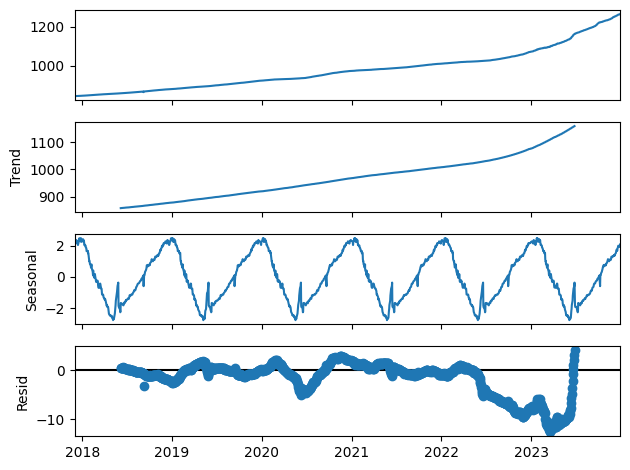

In [9]:
result = seasonal_decompose(USD_exchange_rate, period = 252)
result.plot();

# GPT code

In [10]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_data = scaler.fit_transform(USD_exchange_rate.values.reshape(-1, 1))


In [11]:
normalized_data

array([[0.00000000e+00],
       [2.62047426e-04],
       [4.52226268e-04],
       ...,
       [9.95649659e-01],
       [9.97670309e-01],
       [1.00000000e+00]])

In [12]:
# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

In [13]:
seq_length = 5  # Example sequence length
X, y = create_sequences(normalized_data, seq_length)


In [14]:
# Reshape for LSTM
X = X.reshape((X.shape[0], X.shape[1], 1))  # Ensure the data has shape (samples, timesteps, features)


In [15]:
# Split data into train (80%), validation (10%), and test (10%)
train_size = int(0.8 * len(X))
val_size = int(0.1 * len(X))
test_size = len(X) - train_size - val_size

X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]



In [16]:
# Corresponding dates for validation and test data
train_dates = USD_exchange_rate.index[seq_length:train_size + seq_length]
val_dates = USD_exchange_rate.index[train_size + seq_length:train_size + val_size + seq_length]
test_dates = USD_exchange_rate.index[train_size + val_size + seq_length:]

# preprocess the data

In [17]:
# Print shapes to verify
print("X_train shape:", X_train.shape)  # Should be (number_of_samples, seq_length, 1)
print("y_train shape:", y_train.shape)  # Should be (number_of_samples,)
print("X_val shape:", X_val.shape)      # Should be (number_of_samples, seq_length, 1)
print("y_val shape:", y_val.shape)      # Should be (number_of_samples,)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1200, 5, 1)
y_train shape: (1200, 1)
X_val shape: (150, 5, 1)
y_val shape: (150, 1)
X_test shape: (150, 5, 1)
y_test shape: (150, 1)


In [18]:
# Corresponding dates for validation data
# val_dates = USD_exchange_rate.index[split + seq_length:]

# prepare data for training

In [19]:
# Build the model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

d:\School Doc\python works\Thesis\Scripts\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 5, 50)          │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

create and train LSTM model

In [21]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)


Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0274 - val_loss: 0.0162
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0020 - val_loss: 2.2016e-04
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.0004e-04 - val_loss: 1.5983e-05
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.7954e-04 - val_loss: 9.9606e-05
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.9208e-04 - val_loss: 1.0719e-05
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.3229e-04 - val_loss: 1.5023e-05
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.1350e-04 - val_loss: 5.9487e-06
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.8815e-04 - val_loss: 7.5991e-06
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.2371e-04 - val_loss: 3.5862e-06
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.4815e-04 - val_loss: 3.1077e-04
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.1409e-04 - val_loss: 1.

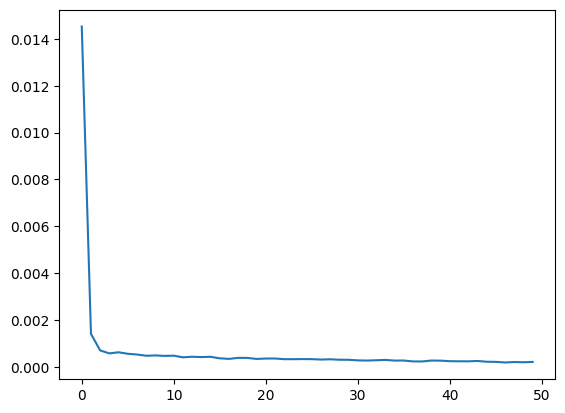

In [22]:
loss_per_epoch = history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [23]:
# Make predictions
predictions_train = model.predict(X_train)
predictions_train = scaler.inverse_transform(predictions_train)
# y_val_actual = scaler.inverse_transform(y_val.reshape(-1, 1))
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


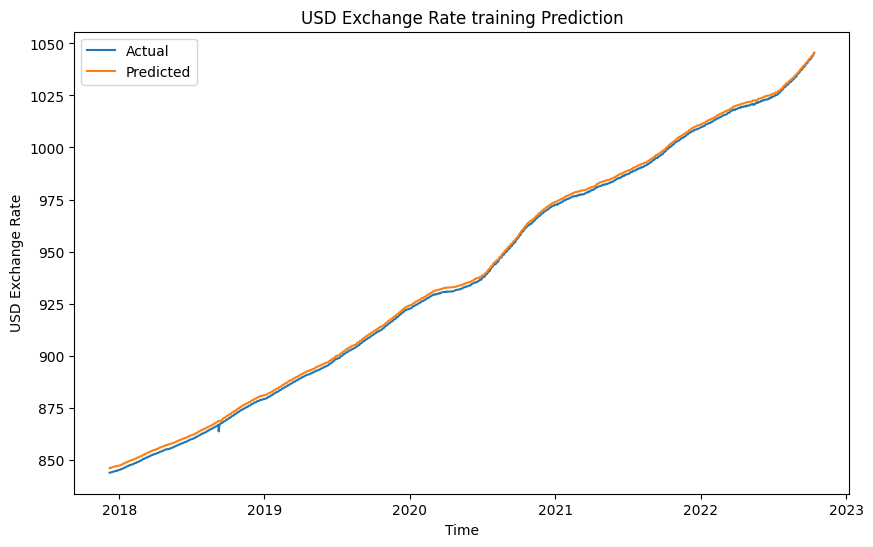

In [24]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train_dates, y_train_actual, label='Actual')
plt.plot(train_dates, predictions_train, label='Predicted')
plt.title('USD Exchange Rate training Prediction')
plt.xlabel('Time')
plt.ylabel('USD Exchange Rate')
plt.legend()
plt.show()

In [25]:
# Calculate MAE
mae_test = mean_absolute_error(y_train_actual, predictions_train)
print(f'Mean Absolute Error for test set (MAE): {mae_test}')

Mean Absolute Error for test set (MAE): 1.528559371396485


In [26]:
# Make predictions
predictions_val = model.predict(X_val)
predictions_val = scaler.inverse_transform(predictions_val)
y_val_actual = scaler.inverse_transform(y_val.reshape(-1, 1))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


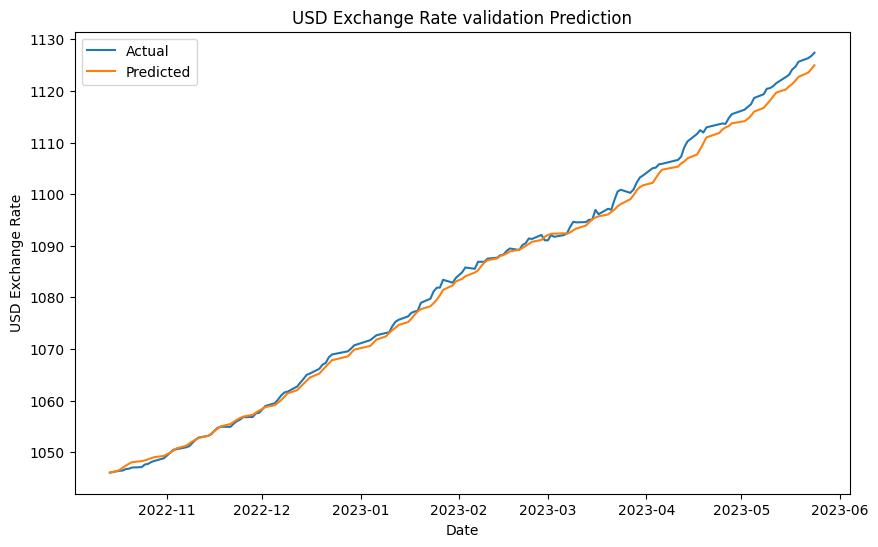

In [27]:
# Plot the results for visualization
plt.figure(figsize=(10, 6))
plt.plot(val_dates, y_val_actual, label='Actual')
plt.plot(val_dates, predictions_val, label='Predicted')
plt.title('USD Exchange Rate validation Prediction')
plt.xlabel('Date')
plt.ylabel('USD Exchange Rate')
plt.legend()
plt.show()

In [28]:
import numpy as np
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

In [29]:
y_train_mean = USD_exchange_rate.mean()
mae_baseline = mean_absolute_error(y_train_actual, ([y_train_mean] * len(y_train)))
print("Mean exchange rate:", y_train_mean)
print("Baseline MAE:", (mae_baseline))

Mean exchange rate: average value    978.820082
dtype: float64
Baseline MAE: 59.23545741036819


In [30]:
# Calculate MAE
mae_val = mean_absolute_error(y_val_actual, predictions_val)
print(f'Mean Absolute Error for validation set (MAE): {mae_val}')

# Calculate the mean of the actual values
mean_actual = np.mean(USD_exchange_rate)
print(f'Mean of actual values: {mean_actual}')

#calculate the baseline
mae_baseline = mean_absolute_error(y_train_actual, ([y_train_mean] * len(y_train)))

print("Baseline MAE:", (mae_baseline))

# Check if MAE is less than the mean of the actual values
if mae_val < mean_actual:
    print("The model's performance is good as MAE is less than the mean of actual values.")
else:
    print("The model's performance is not satisfactory as MAE is greater than or equal to the mean of actual values.")

Mean Absolute Error for validation set (MAE): 1.1034866210937646
Mean of actual values: 978.820081860465
Baseline MAE: 59.23545741036819
The model's performance is good as MAE is less than the mean of actual values.


In [31]:
# Make predictions
predictions_test = model.predict(X_test)
predictions_test = scaler.inverse_transform(predictions_test)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


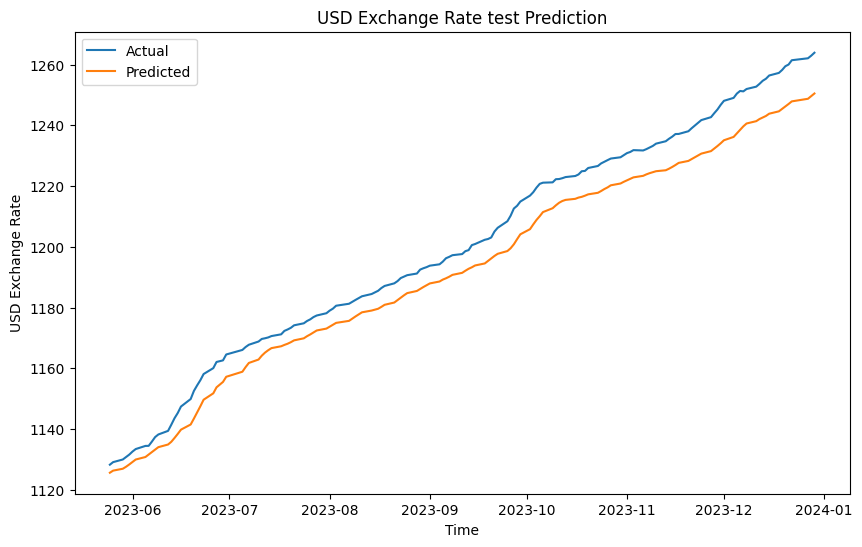

In [32]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(test_dates, y_test_actual, label='Actual')
plt.plot(test_dates, predictions_test, label='Predicted')
plt.title('USD Exchange Rate test Prediction')
plt.xlabel('Time')
plt.ylabel('USD Exchange Rate')
plt.legend()
plt.show()

In [33]:
# Calculate MAE
mae_test = mean_absolute_error(y_test_actual, predictions_test)
print(f'Mean Absolute Error for test set (MAE): {mae_test}')

Mean Absolute Error for test set (MAE): 7.878376177864577
